In [ ]:
# 1. Selenium 및 Chrome Driver 설치 (Colab용)
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

# 2. 한글 폰트 설치 (그래프 깨짐 방지)
!sudo apt-get install -y fonts-nanum -q
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://dl.google.com/linux/chrome/deb stable InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Target Packages (main/binary-amd64/Packages) is configured multiple times in /etc/apt/sources.list.d/google-chrome.list:3 and /etc/apt/so

In [ ]:
import time
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
import re

# --- [함수] 숫자 변환 (변경 없음) ---
def text_to_num(text_num):
    text_num = text_num.replace(',', '').strip()
    if '억' in text_num:
        num = float(re.findall(r'[\d\.]+', text_num)[0]) * 100000000
    elif '만' in text_num:
        num = float(re.findall(r'[\d\.]+', text_num)[0]) * 10000
    else:
        try:
            num = int(text_num)
        except:
            num = 0
    return int(num)

# --- [핵심 수정] 봇 탐지 우회 설정 ---
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('window-size=1920x1080')
# ⚠️ 중요: 이 부분이 추가되었습니다. (브라우저인 척 속이는 코드)
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36")

driver = webdriver.Chrome(options=options)
results = []

print("🚀 크롤링 재시도! (보안 우회 설정 적용됨)")

try:
    for page in range(1, 4): # 1~3페이지
        url = f"https://youtube-rank.com/board/bbs/board.php?bo_table=youtube&page={page}"
        print(f"📄 {page} 페이지 접속 중... ({url})")
        driver.get(url)
        time.sleep(3) # ⚠️ 대기 시간 3초 -> 5초로 늘림 (로딩 확실히 기다림)

        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # --- [수정] 더 넓은 범위로 행(tr) 찾기 ---
        # 기존: form > table > ... (구조가 조금만 바껴도 실패함)
        # 변경: 전체 페이지에서 'tbody' 안에 있는 'tr' 태그들을 모두 찾음
        channel_list = soup.select('tbody > tr')

        # 만약 그래도 못 찾았으면 디버깅용 메시지 출력
        if len(channel_list) == 0:
            print(f"⚠️ 경고: {page} 페이지에서 목록을 찾지 못했습니다. HTML 구조가 변경되었거나 로딩되지 않았습니다.")
            continue

        count_in_page = 0
        for channel in channel_list:
            try:
                # 카테고리 태그가 있는 행만 진짜 데이터임 (광고 행 제외)
                category_tag = channel.select_one('.category')
                if category_tag is None:
                    continue # 카테고리가 없으면 건너뜀

                category = category_tag.text.strip()
                title = channel.select_one('.subject a').text.strip()
                subscriber_text = channel.select_one('.subscriber_cnt').text.strip()
                view_text = channel.select_one('.view_cnt').text.strip()
                video_text = channel.select_one('.video_cnt').text.strip()

                subscriber_num = text_to_num(subscriber_text)

                data = [category, title, subscriber_num, subscriber_text, view_text, video_text]
                results.append(data)
                count_in_page += 1
            except Exception as e:
                # 특정 행에서 에러가 나도 멈추지 않고 다음 행으로
                continue

        print(f"   -> {page} 페이지에서 {count_in_page}개 수집 성공. (누적: {len(results)}개)")

    # 결과 저장
    if len(results) > 0:
        columns = ['카테고리', '채널명', '구독자수(숫자)', '구독자수', '총조회수', '동영상수']
        df = pd.DataFrame(results, columns=columns)
        filename = 'youtube_rank_data.xlsx'
        df.to_excel(filename, index=False)
        print(f"\n✅ 최종 완료! 총 {len(df)}개 데이터 수집됨.")
    else:
        print("\n❌ 여전히 데이터를 하나도 못 찾았습니다. 웹사이트가 Colab 접근을 강력하게 막고 있을 수 있습니다.")

except Exception as e:
    print(f"\n❌ 오류 발생: {e}")

finally:
    driver.quit()



🚀 크롤링 재시도! (보안 우회 설정 적용됨)
📄 1 페이지 접속 중... (https://youtube-rank.com/board/bbs/board.php?bo_table=youtube&page=1)
   -> 1 페이지에서 100개 수집 성공. (누적: 100개)
📄 2 페이지 접속 중... (https://youtube-rank.com/board/bbs/board.php?bo_table=youtube&page=2)
   -> 2 페이지에서 100개 수집 성공. (누적: 200개)
📄 3 페이지 접속 중... (https://youtube-rank.com/board/bbs/board.php?bo_table=youtube&page=3)
   -> 3 페이지에서 100개 수집 성공. (누적: 300개)

✅ 최종 완료! 총 300개 데이터 수집됨.


📊 시각화 결과:


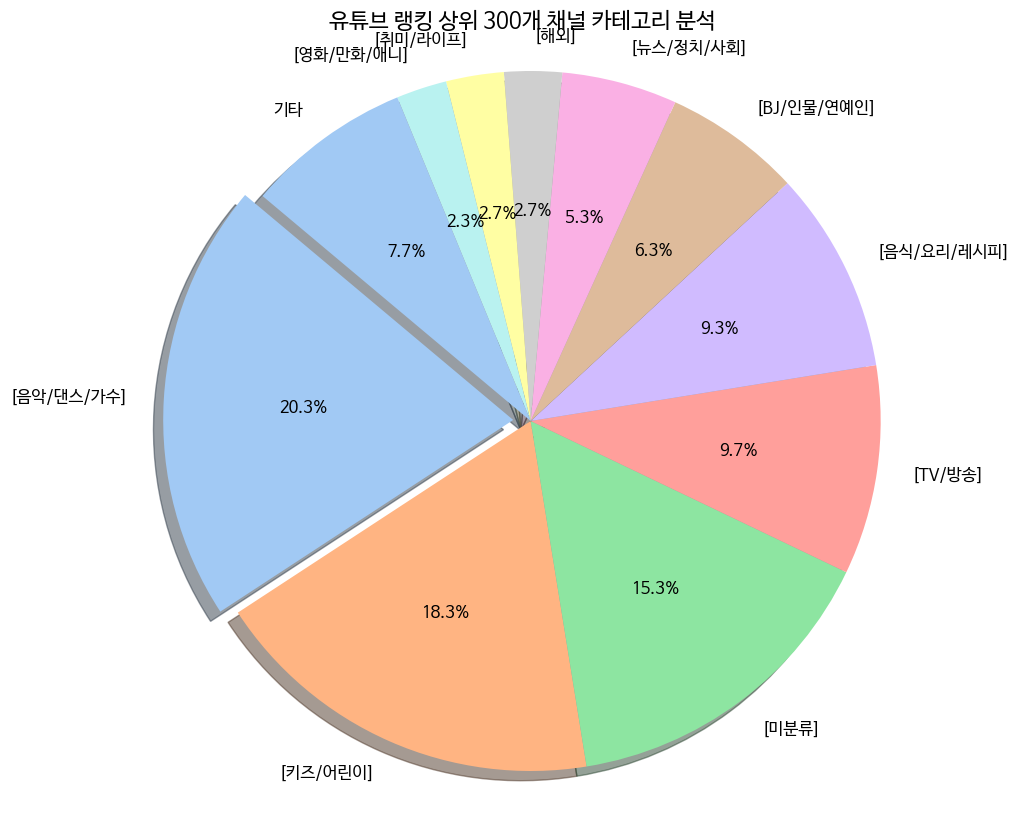


[참고] 수집된 데이터 중 구독자 수 Top 5 채널:
          카테고리            채널명     구독자수
0  [BJ/인물/연예인]      김프로KIMPRO  1억2600만
1   [음악/댄스/가수]      BLACKPINK    9940만
2   [음악/댄스/가수]      BANGTANTV    8180만
3   [음악/댄스/가수]    HYBE LABELS    7920만
4        [미분류]  Justin Bieber    7660만


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- [설정] 그래프 한글 폰트 ---
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 분석: 카테고리별 채널 수 집계
category_counts = df['카테고리'].value_counts()

# 상위 N개 카테고리만 시각화하고 나머지는 '기타'로 묶기 (너무 많으면 그래프가 복잡해짐)
TOP_N = 10
if len(category_counts) > TOP_N:
    top_categories = category_counts[:TOP_N]
    others_count = category_counts[TOP_N:].sum()
    top_categories['기타'] = others_count
    final_counts = top_categories
else:
    final_counts = category_counts

# 2. 시각화: 파이 차트 그리기
plt.figure(figsize=(12, 10))

# 색상 팔레트 설정
colors = sns.color_palette('pastel')[0:len(final_counts)]

# 파이 차트 옵션 설정
# explode: 조각을 약간 떼어내서 강조 (가장 큰 조각 강조)
explode = [0.05 if i == 0 else 0 for i in range(len(final_counts))]

plt.pie(final_counts,
        labels=final_counts.index,
        autopct='%1.1f%%', # 퍼센트 표시 형식
        startangle=140,    # 시작 각도
        colors=colors,
        explode=explode,   # 강조 효과
        shadow=True,       # 그림자 효과
        textprops={'fontsize': 12}) # 텍스트 크기

plt.title(f'유튜브 랭킹 상위 {len(df)}개 채널 카테고리 분석', fontsize=16, fontweight='bold')
plt.axis('equal') # 원을 동그랗게 유지

print("📊 시각화 결과:")
plt.show()

# (추가 정보) 구독자 수 기준 Top 5 채널 출력
print("\n[참고] 수집된 데이터 중 구독자 수 Top 5 채널:")
print(df.sort_values(by='구독자수(숫자)', ascending=False)[['카테고리', '채널명', '구독자수']].head())